In [33]:
import os
import numpy as np
from numpy.linalg import svd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path as pth
from pyslingshot import Slingshot
import random
import anndata as ad
from sklearn.decomposition import PCA

### Set Working Directory

In [9]:
os.chdir(pth.home() / 'traj-alignment')

### Load Data

In [10]:

# set colnames
colnames =['Alcohol','Malic_acid','Ash','Alcalinity_of_ash','Magnesium','Total_phenols','Flavanoids','Nonflavanoid_phenols','Proanthocyanins','Color_intensity','Hue','OD280/OD315_of_diluted_wines','Proline']

colnames = [s.lower() for s in colnames]

wine = pd.read_csv(open('raw-data/wine.data', 'r'), delimiter = ',', index_col=None, names = colnames)
wine_class = wine.index

In [11]:
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Split Data
Make two datasets from same original data. 
- Overlap between samples but not features
- Overlap between samples and features
- No overlap between samples but overlap between features
- No overlap between samples or features

In [12]:
# fix index
wine.index = range(0,wine.shape[0],1)

# Datasets with no sample or feature overlap 
n = wine.shape[0]
p = wine.shape[1]
n_rw = n // 2  
n_col = p // 2  

random.seed(1030)
rw_inds_a = random.sample(range(n), k=n_rw)
rw_inds_b = list(set(range(n)) - set(rw_inds_a))

a_class = wine_class[rw_inds_a]
b_class = wine_class[rw_inds_b]

col_inds_a = random.sample(range(p), k = n_col)
col_inds_b = list(set(range(p)) - set(col_inds_a))


In [13]:
a = wine.iloc[rw_inds_a, col_inds_a]
b = wine.iloc[rw_inds_b, col_inds_b]


In [14]:

x = np.unique(np.concatenate([a.columns.values, b.columns.values]))
print('diff =', len(wine.columns.difference(x)),"columns")
# print(wine.columns)

diff = 0 columns


### Scale data and calculate pcs

In [15]:
# 0 mean unit variance
standardize = lambda x:  x.sub(x.mean(axis=0), axis = 1).div(x.std(axis =0), axis = 1)

#PCs
def get_PCs(X):
    pcs = PCA( n_components = 4).fit_transform(X)
    pcs = pd.DataFrame(pcs)
    pcs.columns = [f"PC{i}" for i in range(pcs.shape[1])]
    return pcs

a_scld = standardize(a)
b_scld = standardize(b)

aPCA = get_PCs(a_scld)
bPCA = get_PCs(b_scld)


In [16]:

print(type(aPCA))
print(aPCA.shape)

<class 'pandas.core.frame.DataFrame'>
(89, 4)


##### Plot PCS

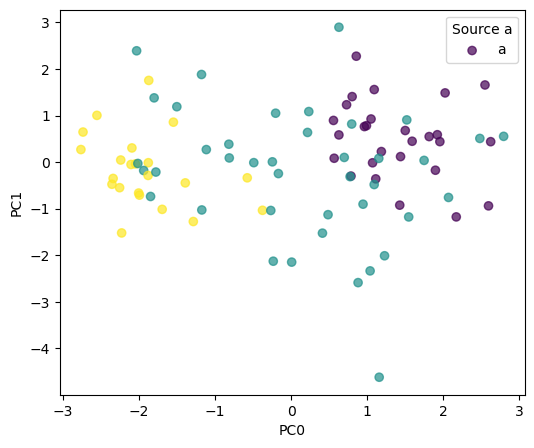

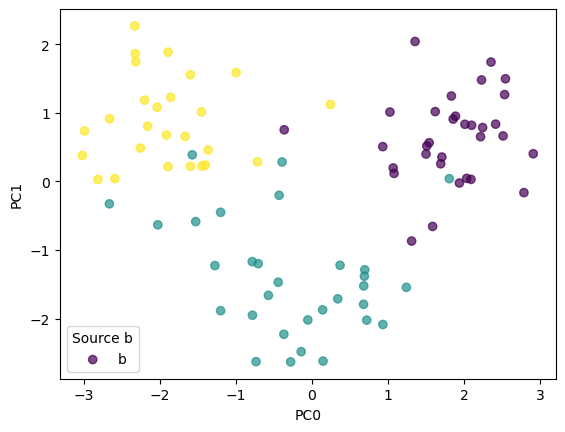

In [17]:
a = (
    aPCA
    .assign(source = 'a')
)
b = (
    bPCA
    .assign(source = 'b')
)

plot_df = pd.concat([a, b], axis=0, ignore_index=True)
plot_df["class"] = np.concatenate([a_class, b_class])

plt.figure(figsize=(6, 5))

for s in plot_df["source"].unique():
    mask = plot_df["source"] == s
    plt.scatter(
        plot_df.loc[mask, "PC0"],
        plot_df.loc[mask, "PC1"],
        c=plot_df.loc[mask, "class"],
        label=s,
        alpha=0.7
    )
    plt.xlabel("PC0")
    plt.ylabel("PC1")
    plt.legend(title=f"Source {s}")
    plt.show()


### Calculate Trajectories


In [24]:

def make_annData(X,labels):
    if X.shape[0] != len(labels):
        raise ValueError(
            f"X index and labels must have the same length, got {X.shape[0]} and len(labels)={len(labels)}"
        )
    else:
        num_samp = X.shape[0]
        num_feat = X.shape[1]
        ad = AnnData(np.zeros((num_samp, num_feat)))
        ad.obsm["PCA"] = X
        ad.obs["labels"] = labels
        return ad

In [48]:
# make_annData(X = aPCA, labels = a_class)
x = ad.AnnData(a_scld)
x.obsm['PCA'] = np.array(aPCA)
x.obs['class'] = a_class


/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


### Compute svd

In [ ]:
aU, aS, aV = svd(a_scld)
bU, bS, bV = svd(b_scld)

print("Row Vectors = ", aU.shape)
print("Column Vectors = ",aS.shape)
print("Singular Values = ", aV.shape)

### Orthogonal Procrustes alignment (map  __B__ --> __A__)

Given centered and scaled matrices
$$
A, B \in \mathbb{R}^{n \times p},
\qquad
R \in \mathbb{R}^{p \times p},
$$
we estimate an orthogonal transformation that aligns __B__ to __A__ by solving

$$
R^* \;=\;
\arg\min_{R \in \mathbb{R}^{p \times p}}
\;\| B R - A \|_F^2
\quad \text{subject to} \quad
R^\top R = I .
$$

Let the cross-covariance matrix be

$$
M = B^\top A .
$$

If the singular value decomposition of \(M\) is

$$
M = U \Sigma V^\top ,
$$

then the optimal rotation matrix is given by

$$
R^* = U V^\top .
$$
